In [ ]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
colors = {
    "Blue": "#1f77b4",
    "Green": "#2ca02c",
    "Red": "#d62728",
    "Grey": "#7f7f7f",
}

from datetime import datetime
import holidays

from pyspark.sql import SparkSession
import os
event_log_dir = "/tmp/spark-events"
os.makedirs(event_log_dir, exist_ok=True)

total_memory_gb = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024. ** 3)

spark = SparkSession.builder \
    .appName("GeoAnalysisDDAM") \
    .config("spark.executor.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.driver.memory", f"{int(total_memory_gb * 0.8)}g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/tmp/spark-events") \
    .getOrCreate()
sc = spark.sparkContext

file_path = '/content/drive/MyDrive/DDAM Group 2/geo_offline_pre_combined.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

Mounted at /content/drive
root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- prev_lat: double (nullable = true)
 |-- prev_long: double (nullable = true)
 |-- distance_from_home: double (nullable = true)

+---------------------+-----------+------------+-------------+-----+-------+--------+--------------------+------------------+------------------+--------+----+---+-----+---+------------------+------------------+------------------+
|trans_date_trans

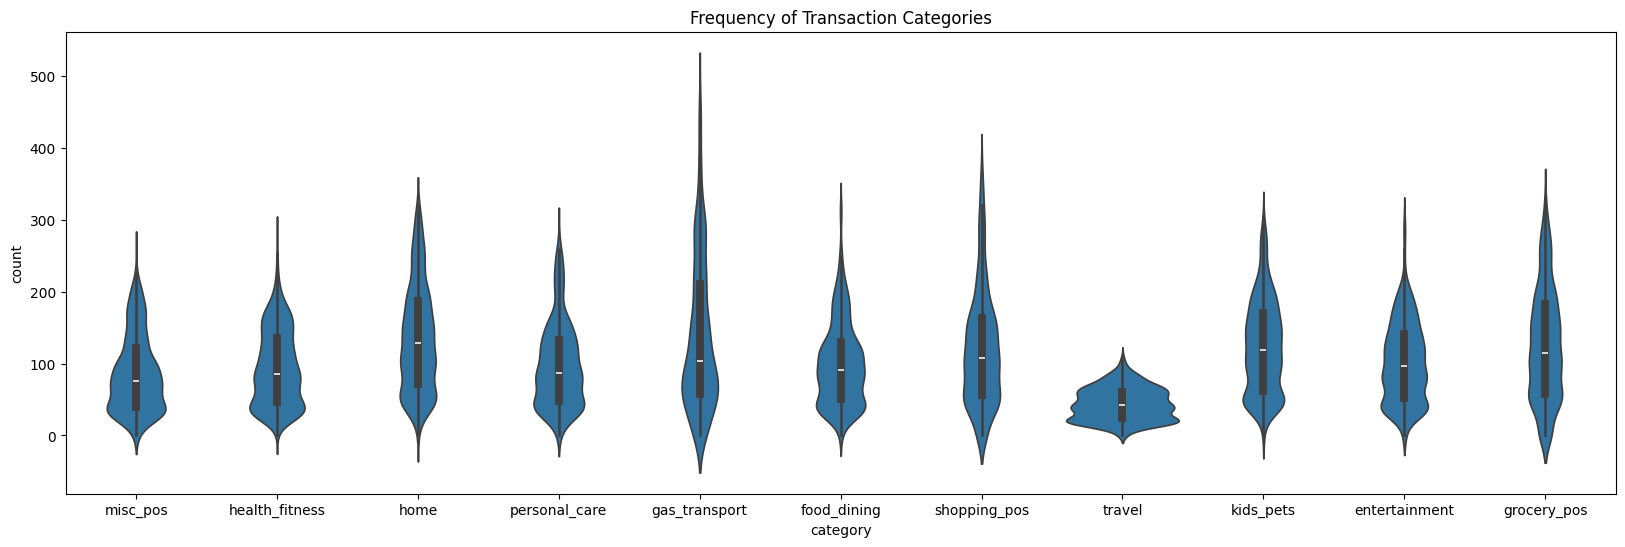

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Group by cc_num and category, count frequencies
transaction_counts = df.groupBy("cc_num", "category").count()

windowSpec = Window.partitionBy("cc_num").orderBy("trans_date_trans_time")
transaction_chain = df.withColumn("prev_category", F.lag("category").over(windowSpec))

import seaborn as sns
import matplotlib.pyplot as plt

transaction_counts_pd = transaction_counts.toPandas()
plt.figure(figsize=(20,6))
sns.violinplot(x='category', y='count', data=transaction_counts_pd)
plt.title('Frequency of Transaction Categories')
plt.show()

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# encode category column
indexer = StringIndexer(inputCol="category", outputCol="category_index")
df = indexer.fit(df).transform(df)
# one-hot encoding
encoder = OneHotEncoder(inputCol="category_index", outputCol="category_vec")
df = encoder.fit(df).transform(df)

from pyspark.ml.feature import VectorAssembler

# features extraction per user
user_stats = df.groupBy("cc_num").agg(
    F.sum("amt").alias("total_spend"),
    F.avg("amt").alias("avg_spend"),
    F.count("trans_num").alias("transaction_count"),
    F.avg("distance_from_home").alias("avg_distance"),
    F.avg("hour").alias("avg_hour"),
    F.avg("lat").alias("avg_lat"),
    F.avg("long").alias("avg_long"),
    F.first("category_vec").alias("category_vec")
)

feature_columns = [
    "total_spend", "avg_spend", "transaction_count", "avg_distance",
    "avg_hour", "avg_lat", "avg_long", "category_vec"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
user_features = assembler.transform(user_stats)

In [ ]:
!pip install kneed -q -q -q

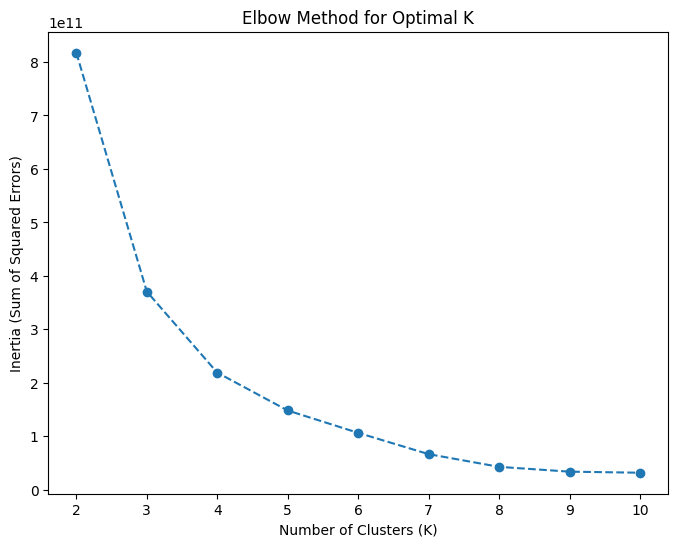

Optimal number of clusters according to Kneedle Locator: 4
+-----------+----------+
|     cc_num|prediction|
+-----------+----------+
|60416207185|         3|
|60422928733|         1|
|60423098130|         3|
|60427851591|         0|
|60487002085|         0|
+-----------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(user_features)
    inertia.append(model.summary.trainingCost)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Errors)")
plt.title("Elbow Method for Optimal K")
plt.show()

kneedle = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow
print(f"Optimal number of clusters according to Kneedle Locator: {optimal_k}")

kmeans = KMeans().setK(optimal_k).setSeed(1)
model = kmeans.fit(user_features)

predictions = model.transform(user_features)
predictions.select("cc_num", "prediction").show(5)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

Silhouette score = 0.7184865051635766


In [ ]:
predictions.printSchema()

root
 |-- cc_num: long (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- avg_spend: double (nullable = true)
 |-- transaction_count: long (nullable = false)
 |-- avg_distance: double (nullable = true)
 |-- avg_hour: double (nullable = true)
 |-- avg_lat: double (nullable = true)
 |-- avg_long: double (nullable = true)
 |-- category_vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [ ]:
import plotly.express as px

cluster_data = predictions.select("total_spend", "avg_distance", "transaction_count", "prediction").toPandas()

fig = px.scatter_3d(
    cluster_data,
    x="total_spend",
    y="avg_distance",
    z="transaction_count",
    color="prediction",
    color_continuous_scale='Bluered',
    title="3D Clustering Visualization",
    labels={"total_spend": "Total Spend", "avg_distance": "Avg Distance", "transaction_count": "Transaction Count"}
)
fig.show()

In [ ]:
predictions.printSchema()

root
 |-- cc_num: long (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- avg_spend: double (nullable = true)
 |-- transaction_count: long (nullable = false)
 |-- avg_distance: double (nullable = true)
 |-- avg_hour: double (nullable = true)
 |-- avg_lat: double (nullable = true)
 |-- avg_long: double (nullable = true)
 |-- category_vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [ ]:
predictions_to_scale = predictions.drop('features')

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["total_spend", "avg_spend", "transaction_count", "avg_distance", "avg_hour"],
    outputCol="features"
)
assembled_data = assembler.transform(predictions_to_scale)

# scale from 0 to 1
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

<ipython-input-46-3dd55986c5d5>:59: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



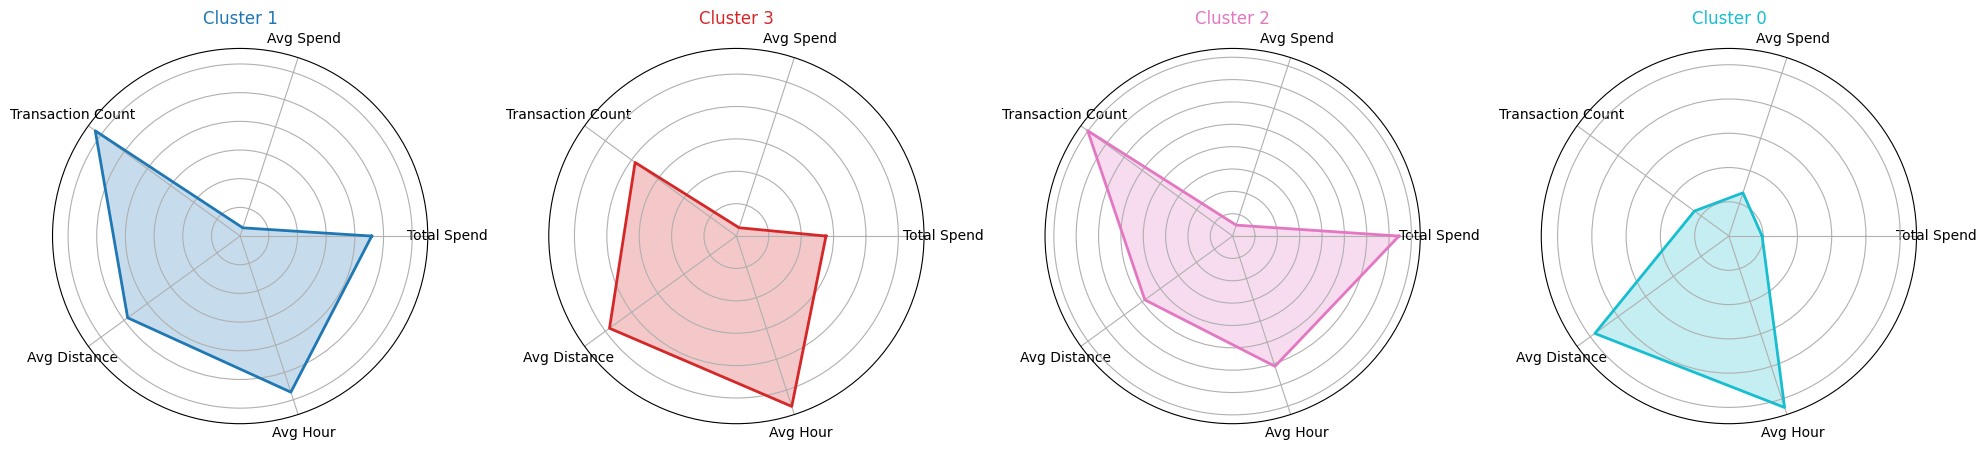

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import ArrayType, DoubleType
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def convert_to_list(vec):
    return vec.toArray().tolist() if vec else []

convert_udf = udf(convert_to_list, ArrayType(DoubleType()))

scaled_data = scaled_data.withColumn("scaled_features_list", convert_udf(col("scaled_features")))
scaled_data = scaled_data.withColumn("total_spend_scaled", col("scaled_features_list")[0])
scaled_data = scaled_data.withColumn("avg_spend_scaled", col("scaled_features_list")[1])
scaled_data = scaled_data.withColumn("transaction_count_scaled", col("scaled_features_list")[2])
scaled_data = scaled_data.withColumn("avg_distance_scaled", col("scaled_features_list")[3])
scaled_data = scaled_data.withColumn("avg_hour_scaled", col("scaled_features_list")[4])

scaled_cluster_means = scaled_data.groupBy("prediction").agg(
    F.avg("total_spend_scaled").alias("avg_total_spend_scaled"),
    F.avg("avg_spend_scaled").alias("avg_avg_spend_scaled"),
    F.avg("transaction_count_scaled").alias("avg_transaction_count_scaled"),
    F.avg("avg_distance_scaled").alias("avg_avg_distance_scaled"),
    F.avg("avg_hour_scaled").alias("avg_avg_hour_scaled")
)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")


scaled_cluster_means_pandas = scaled_cluster_means.toPandas()
clusters = scaled_cluster_means_pandas['prediction'].tolist()
categories = ['Total Spend', 'Avg Spend', 'Transaction Count', 'Avg Distance', 'Avg Hour']

num_clusters = len(clusters)
fig, axes = plt.subplots(1, num_clusters, subplot_kw=dict(projection='polar'), figsize=(5 * num_clusters, 5))

if num_clusters == 1:
    axes = [axes]


# color palette for clusters
color_palette = cm.get_cmap('tab10', num_clusters)

# radar plot for each cluster
for idx, cluster in enumerate(clusters):
    cluster_scaled_values = scaled_cluster_means_pandas[
        scaled_cluster_means_pandas['prediction'] == cluster
    ].iloc[0, 1:].tolist()

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    cluster_scaled_values += cluster_scaled_values[:1]
    angles += angles[:1]

    ax = axes[idx]
    cluster_color = color_palette(idx)
    ax.fill(angles, cluster_scaled_values, color=cluster_color, alpha=0.25)
    ax.plot(angles, cluster_scaled_values, color=cluster_color, linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.set_title(f'Cluster {cluster}', color=cluster_color)

plt.tight_layout()
plt.show()